<a href="https://www.kaggle.com/code/askadetov/booking-review-kadetov-andrey?scriptVersionId=138253381" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

# Импортируем библиотеку для работы с тональностью речи
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# для нормализации, стандартизации
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Состав датасета:
  
  0. hotel_address — адрес отеля;
  1. additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
  2. review_date — дата, когда рецензент разместил соответствующий отзыв;
  3. average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
  4. hotel_name — название отеля;
  5. reviewer_nationality — страна рецензента;
  6. negative_review — отрицательный отзыв, который рецензент дал отелю;
  7. review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
  8. total_number_of_reviews — общее количество действительных отзывов об отеле;
  9. positive_review — положительный отзыв, который рецензент дал отелю;
  10. review_total_positive_word_counts — общее количество слов в положительном отзыве.
  11. total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
  12. tags — теги, которые рецензент дал отелю;
  13. days_since_review — количество дней между датой проверки и датой очистки;
  14. lat — географическая широта отеля;
  15. lng - географическая долгота отеля;
  16. sample - указатель, где трейн, а где тест датасет;
  17. reviewer_score - колонка для предсказания оценки.

# 1. Очистка данных от выбросов

Посмотрим на распределение оценок и определим, есть ли здесь выбросы, для этого возьмем только данные из тренировочного датафрейма:

<AxesSubplot:xlabel='reviewer_score', ylabel='Count'>

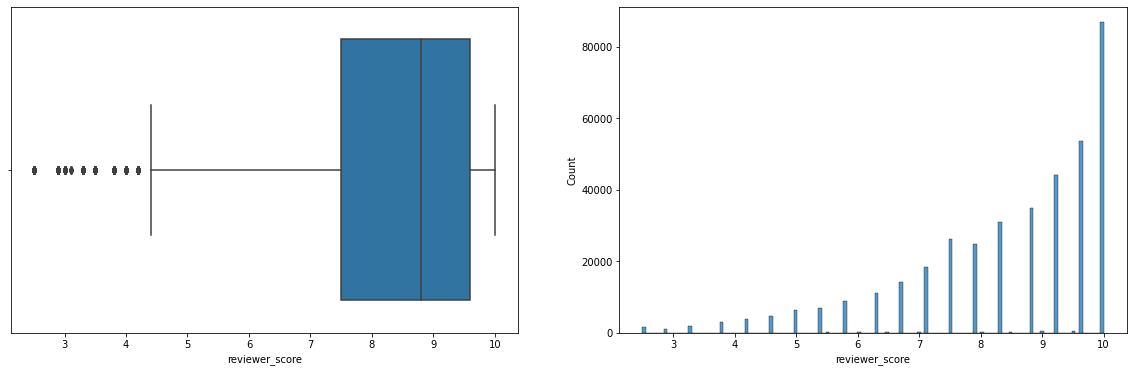

In [13]:
# Введем размер фигуры
plt.figure(figsize=(20, 6)) 

# Построим коробчатую диаграмму
plt.subplot(121)
sns.boxplot(data=data[data['sample'] == 1], x="reviewer_score")

# Построим гистограмму распределения
plt.subplot(122)
sns.histplot(data=data[data['sample'] == 1], x="reviewer_score")

Распределение похоже на нормальное. Несмотря на то, что коробчатая диаграмма показывает нам выбросы, я не думаю что маленькие оценки можно считать таковыми, потому что количество маленьких оценок уменьшается равномерно с уменьшением оценки. Поэтому пока ничего удалять не буду. Отмечу, что основная масса оценок находится в промежутке 7.5 - 10. Также отмечу, что что большинство оценок являются нецелыми числами, что может показаться странным на первый взгляд, так как вряд-ли большинство людей будет ставить к примеру оценку 9,2 а не 9. Я думаю это объясняется тем, что после поездки букинг просит поставить несколько оценок по разным категориям, а здесь уже представлена средняя оценка. Среди остальных столбцов я пока не вижу в каком из них могли бы быть выбросы, поэтому пока больше не будем удалять никаких строк. 

# 2. Заполнение пропущенных значений.

Датасет практически не имеет пропусков, исключение - 2 столбца с геоданными. Поэтому заполним эти пропуски. Будет некорректно заполнять эти пропуски медианным или средним значением, потому что здесь важна точность геопозиции, иначе эти данные потеряют смысл. Узнаем какое количество отелей не имеют координат:

In [14]:
# Проверим, что в тех строках где не указана широта, долгота тоже не указана и наоборот

print(data[data['lat'].isna()].shape[0])
print(data[data['lng'].isna()].shape[0])
print(data[(data['lat'].isna()) & (data['lng'].isna())].shape[0])

3268
3268
3268


In [15]:
# Выведем список отелей
print(data[data['lat'].isna()]['hotel_name'].nunique())
data[data['lat'].isna()]['hotel_name'].unique()

17


array(['Hotel Atlanta', 'City Hotel Deutschmeister',
       'Holiday Inn Paris Montmartre',
       'Fleming s Selection Hotel Wien City', 'Hotel City Central',
       'Cordial Theaterhotel Wien', 'NH Collection Barcelona Podium',
       'Hotel Daniel Vienna', 'Maison Albar Hotel Paris Op ra Diamond',
       'Mercure Paris Gare Montparnasse',
       'Hotel Pension Baron am Schottentor',
       'Austria Trend Hotel Schloss Wilhelminenberg Wien',
       'Renaissance Barcelona Hotel',
       'Derag Livinghotel Kaiser Franz Joseph Vienna', 'Roomz Vienna',
       'Hotel Park Villa', 'Hotel Advance'], dtype=object)

##### В общей сложности 17 отелей. Небольшое количество, поэтому не проблема внести геоданные этих отелей вручную:

In [16]:
# Заполним все пропуски вручную
data.loc[(data['hotel_name']=='Hotel Atlanta'),['lat', 'lng']] = 48.220332, 16.355862
data.loc[(data['hotel_name']=='City Hotel Deutschmeister'),['lat', 'lng']] = 48.220931, 16.366365
data.loc[(data['hotel_name']=='Holiday Inn Paris Montmartre'),['lat', 'lng']] = 48.888868, 2.333248
data.loc[(data['hotel_name']=='Fleming s Selection Hotel Wien City'),['lat', 'lng']] = 48.209342, 16.353448
data.loc[(data['hotel_name']=='Hotel City Central'),['lat', 'lng']] = 48.213596, 16.379845
data.loc[(data['hotel_name']=='Cordial Theaterhotel Wien'),['lat', 'lng']] = 48.209424, 16.351490
data.loc[(data['hotel_name']=='NH Collection Barcelona Podium'),['lat', 'lng']] = 41.391542, 2.177890
data.loc[(data['hotel_name']=='Hotel Daniel Vienna'),['lat', 'lng']] = 48.188731, 16.383783
data.loc[(data['hotel_name']=='Maison Albar Hotel Paris Op ra Diamond'),['lat', 'lng']] = 48.875384, 2.294563
data.loc[(data['hotel_name']=='Mercure Paris Gare Montparnasse'),['lat', 'lng']] = 48.838928, 2.322493
data.loc[(data['hotel_name']=='Hotel Pension Baron am Schottentor'),['lat', 'lng']] = 48.216755, 16.359753
data.loc[(data['hotel_name']=='Austria Trend Hotel Schloss Wilhelminenberg Wien'),['lat', 'lng']] = 48.219445, 16.285898
data.loc[(data['hotel_name']=='Renaissance Barcelona Hotel'),['lat', 'lng']] = 41.392598, 2.167304
data.loc[(data['hotel_name']=='Derag Livinghotel Kaiser Franz Joseph Vienna'),['lat', 'lng']] = 48.245561, 16.343073
data.loc[(data['hotel_name']=='Roomz Vienna'),['lat', 'lng']] = 48.222807, 16.393767
data.loc[(data['hotel_name']=='Hotel Park Villa'),['lat', 'lng']] = 48.233393, 16.345637
data.loc[(data['hotel_name']=='Hotel Advance'),['lat', 'lng']] = 41.385014, 2.161568

# Проверим что пропусков не осталось
print(data[data['lat'].isna()].shape[0])
print(data[data['lng'].isna()].shape[0])

0
0


# 3. Создание и преобразование признаков

Из 18 столбцов в нашем датафрейме 7 столбцов имеют тип данных object. В конечном итоге для обучения модели требуется чтобы все столбцы имели числовой вид, поэтому нам потребуется либо преобразовать столбцы в числовой вид, либо извлечь из них информацию и привести ее к числовому виду. Проведем работу поочередно с каждым из столбцов.

## 3.1. Признак days_since_review 
Извлечем количество дней из данного столбца и преобразуем его в числовой вид:

In [17]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

Пока сложно сказать чем может быть полезен данный признак, поэтому просто оставлю его в таком виде

## 3.2. Признак hotel_address
Посмотрим какую информацию предоставляет данная колонка:

In [18]:
for row in data['hotel_address'].head(15):
    print(row)

Via Senigallia 6 20161 Milan Italy
Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands
Mallorca 251 Eixample 08008 Barcelona Spain
Piazza Della Repubblica 17 Central Station 20124 Milan Italy
Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands
Coram Street Camden London WC1N 1HT United Kingdom
Empire Way Wembley Brent London HA9 8DS United Kingdom
1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom
35 Rue Caumartin 9th arr 75009 Paris France
49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom
Via Giorgio Stephenson 55 20157 Milan Italy
Spaarndammerdijk 304 Westerpark 1013 ZX Amsterdam Netherlands
Damrak 1 5 Amsterdam City Center 1012 LG Amsterdam Netherlands
Caspe 103 Eixample 08013 Barcelona Spain
Via Napo Torriani 24 Central Station 20124 Milan Italy


В начале адреса указывается улица и номер дома, затем район и почтовый индекс, в самом конце указывается страна, а перед страной город у всех, кроме Великобритании. У нее город находится на 5 месте с конца. Таким образом мы можем создать признак 'country' и 'city':

In [19]:
# Создадим признаки при помощи лямбда функций
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1]=='Kingdom' else x.split()[-2])

# Выведем уникальные значения:
print(data['hotel_country'].unique())
print(data['hotel_city'].unique())

['Italy' 'Netherlands' 'Spain' 'United Kingdom' 'France' 'Austria']
['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']


Мы видим, что от каждой страны в таблице по одному городу, поэтому один из этих признаков следует удалить. Сейчас я пока воздержусь от этого, сделаю это позже. Визуализируем распределение оценок в зависимости от города:

<AxesSubplot:title={'center':'Распределение оценок в зависимости от города'}, xlabel='hotel_city', ylabel='reviewer_score'>

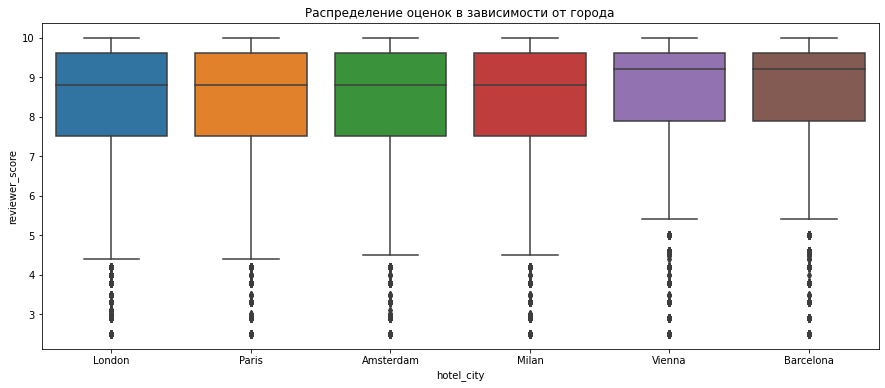

In [20]:
plt.figure(figsize=(15,6)) 
plt.title("Распределение оценок в зависимости от города")
sns.boxplot(data=data[data['sample']==1], x='hotel_city', y='reviewer_score')

На графике видно, что немного выше оценки у Барселоны и Вены. Что же касается адреса, то здесь можно выделить еще один признак - почтовый индекс или код, который указывает на то, в каком районе расположен отель. Район может влиять на итоговую оценку, поэтому выделим этот признак:

239


<AxesSubplot:xlabel='post_code'>

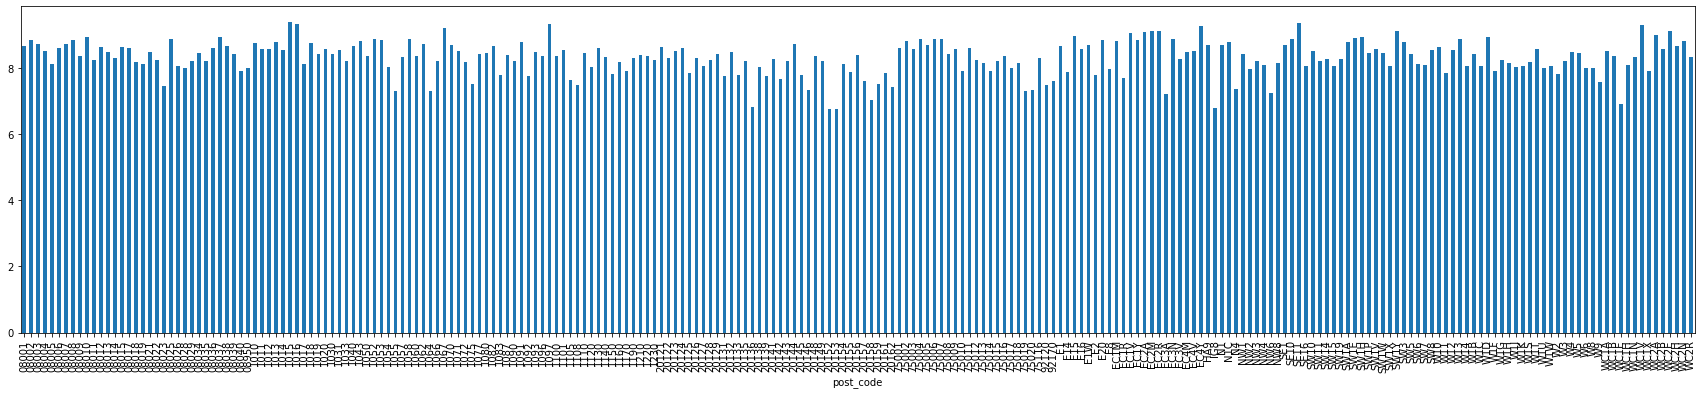

In [21]:
# В адресах Амстердама и Лондона этот признак находится на 4 месте с конца, а у остальных - третий с конца, 
# напишем функцию для извлечения кода:
def get_post_code(row):
    if (row['hotel_city'] == 'Amsterdam') or (row['hotel_city'] == 'London'):
        return row['hotel_address'].split()[-4]
    else:
        return row['hotel_address'].split()[-3]

# Применим фунуцию
data['post_code'] = data[['hotel_address', 'hotel_city']].apply(get_post_code, axis=1)

# Посмотрим сколько уникальных значений получилось
print(data['post_code'].nunique())

# Построим столбчатую диаграмму, чтобы посмотреть, влияет ли район на оценку.
data[data['sample']==1].groupby('post_code')['reviewer_score'].mean().plot(kind='bar', figsize=(30, 6))

График подтверждает мои догадки, что район оказывает влияние на оценку. Теперь в колонке с адресом больше не осталось нужных нам данных, название улицы и номер дома нам не понадобятся, так как у нас есть почтовый код, который выглядит информативнее, поэтому удалим столбец с адресом. А созданные признаки закодируем. Для колонки hotel_city будем использовать однократное кодирование, а для колонки post_code - двоичное.

In [22]:
# Удалим столбец
data = data.drop('hotel_address', axis=1)

In [23]:
# Воспользуемся кодировщиком OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True) 
city_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, city_bin], axis=1)
data = data.drop('hotel_city', axis=1)

In [24]:
# Воспользуемся кодировщиком BinaryEncoder
bin_encoder = ce.BinaryEncoder(cols=['post_code'])
post_code_bin = bin_encoder.fit_transform(data['post_code'])
data = pd.concat([data, post_code_bin], axis=1)
data = data.drop('post_code', axis=1)

## 3.3. Признак reviewer_nationality

Посмотрим какое количество национальностей всего представлено в списке и на распределение национальностей:

In [25]:
print(data['reviewer_nationality'].nunique())
data['reviewer_nationality'].value_counts().head(25)

227


 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
Name: reviewer_nationality, dtype: int64

На лицо лидерство с большим отрывом граждан Великобритании, остальные национальности распределены более равномерно. В первую очередь приходит мысль создать признак 'review_by_resident', который будет принимать 1, если оценка поставлена резидентом данной страны и 0, если поставлена иностранцем. Здесь нам как раз пригодится столбец с названием страны. Сделаем это:

<AxesSubplot:title={'center':'Разница между оценками резидентов и нерезидентов'}, xlabel='review_by_resident', ylabel='reviewer_score'>

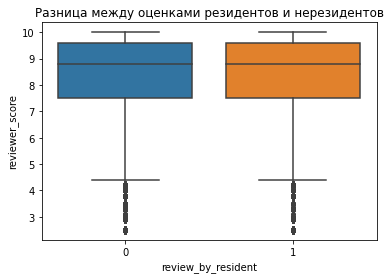

In [26]:
# Уберем сначала пробелы по обе стороны в каждой строке колонки reviewer_nationality
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])

# Напишем функцию
def by_resident(row):
    if row['hotel_country'] == row['reviewer_nationality']:
        return 1
    else:
        return 0

# Применим её
data['review_by_resident'] = data[['reviewer_nationality', 'hotel_country']].apply(by_resident, axis=1)

# И визуализируем влияние данного признака
plt.title("Разница между оценками резидентов и нерезидентов")
sns.boxplot(data=data[data['sample']==1], x='review_by_resident', y='reviewer_score')

Как видим диаграммы идентичны, но пока удалять этот признак не буду, удалю только признак 'hotel_country'. Что же касается признака 'reviewer_nationality', то следует изучить, оказывает ли он влияние. Для этого составим список из 25 наиболее часто встречающихся национальностей, а затем национальности, которые не входят в этот список заменим на 'Other'. Затем визуализируем, чтобы посмотреть влияет ли данный признак на оценку.

In [27]:
data = data.drop('hotel_country', axis=1)

<AxesSubplot:title={'center':'Влияние признака национальность на оценку'}, xlabel='reviewer_nationality', ylabel='reviewer_score'>

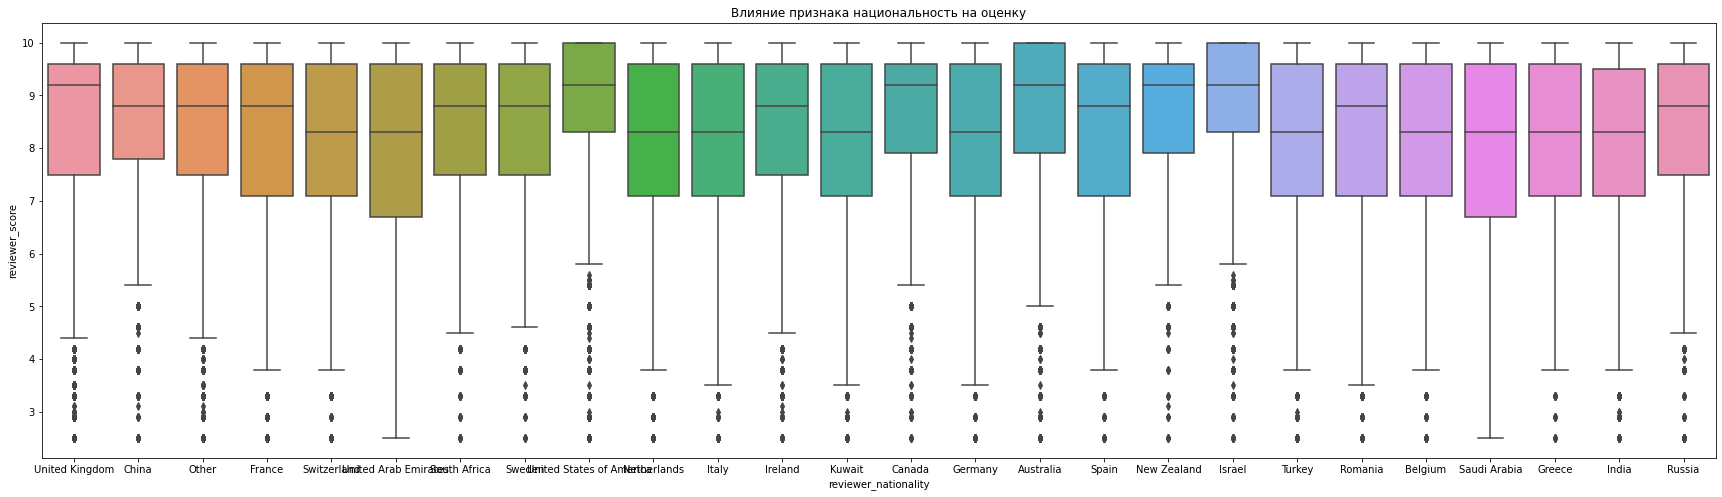

In [28]:
# Создаем список
nation_list = list(data['reviewer_nationality'].value_counts().nlargest(25).index)

# Преобразовываем список
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'Other' if x not in nation_list else x)

# Визуализируем
plt.figure(figsize=(30 ,8))
plt.title("Влияние признака национальность на оценку")
sns.boxplot(data=data[data['sample']==1], x='reviewer_nationality', y='reviewer_score')

Мы видим, что различие в оценках имеется, поэтому оставим этот признак, а для того чтобы привести его к читаемому виду, закодируем его методом двоичного кодирования:

In [29]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
reviewer_nationality_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, reviewer_nationality_bin], axis=1)
data = data.drop('reviewer_nationality', axis=1)

# 3.4. Признак tags

Теперь посмотрим что из себя представляет столбец с тэгами:

In [30]:
for row in data['tags'].head(15):
    print(row)

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']
[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']
[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']
[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' Business trip ', ' Solo traveler ', ' Standard Double or Twin Room ', ' Stayed 1 night ']
[' Leisure trip ', ' Couple ', ' Queen Room ', ' Stayed 1 night ']
[' Business trip ', ' Solo traveler ', ' Executive Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' Group ', ' Double or Twin Room ', ' Stayed 1 night ']
[' Couple ', ' Standard Triple Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ']
[' Leisure trip ', ' Group ', ' Large R

Из тэгов можно выделить несколько признаков:
  + цель поездки: бизнес или отдых;
  + количество человек в группе
  + вид номера
  + количество ночей
  + оставлен ли отзыв с мобильного устройства

И возможно, что-то еще, но начнем по порядку. Каждый тэг представлен в виде строки, поэтому чтобы удобнее было работать с ним дальше, поменяем каждую строку на список тэгов:

In [31]:
# Напишем функцию, которая преобразовывает строку с тэгами в список
def get_tags_list(string):
    string = string.replace(', ', '')
    string = string[2:-2]
    tags_list = string.split("''")
    return tags_list

# Применим функцию
data['tags'] = data['tags'].apply(get_tags_list)
data['tags'].head()

0    [ Leisure trip ,  Couple ,  Double Room ,  Sta...
1    [ Leisure trip ,  Group ,  Triple Room ,  Stay...
2    [ Business trip ,  Solo traveler ,  Twin Room ...
3    [ Leisure trip ,  Couple ,  Ambassador Junior ...
4    [ Business trip ,  Solo traveler ,  Classic Do...
Name: tags, dtype: object

Теперь хочется узнать сколько всего тэгов и насколько они популярны. Создадим пустой словарь, затем пройдемся по каждой строчке в колонке с тэгами, посчитаем количество повторений каждого тэга и поместим эти значения в словарь, а затем преобразуем его в сериес:

In [32]:
# Создаем пустой словарь
dict_tags = {}

# Пройдемся по тэгам
for row in data['tags']:
    for tag in row:
        if tag in dict_tags:
            dict_tags[tag] += 1
        else:
            dict_tags[tag] = 1
            
tags_series = pd.Series(dict_tags) # создадим сериес
tags_series = tags_series.sort_values(ascending=False) # отсортируем
print(tags_series.shape[0]) # узнаем длину, т.е. количество тэгов
tags_series.head(15) # выведем самые популярные

2428


 Leisure trip                       417778
 Submitted from a mobile device     307640
 Couple                             252294
 Stayed 1 night                     193645
 Stayed 2 nights                    133937
 Solo traveler                      108545
 Stayed 3 nights                     95821
 Business trip                       82939
 Group                               65392
 Family with young children          61015
 Stayed 4 nights                     47817
 Double Room                         35207
 Standard Double Room                32248
 Superior Double Room                31393
 Family with older children          26349
dtype: int64

Всего получилось 2428 тэгов - достаточно много. В большинстве своем это тэги, связанные с описанием номера. Но начнем по порядку: сначала выделим признак, характеризующий цель поездки:

In [33]:
# Проверим сколько всего тэгов связаны с целью поездки
purpose_trip = set()

for elem in tags_series.index:
    if 'trip' in elem:
        purpose_trip.add(elem)
        
purpose_trip

{' Business trip ', ' Leisure trip '}

Leisure trip     417778
Business trip     82939
Unknown           15021
Name: purpose_trip, dtype: int64


<AxesSubplot:title={'center':'Зависимость оценки посетителя от цели поездки'}, xlabel='purpose_trip', ylabel='reviewer_score'>

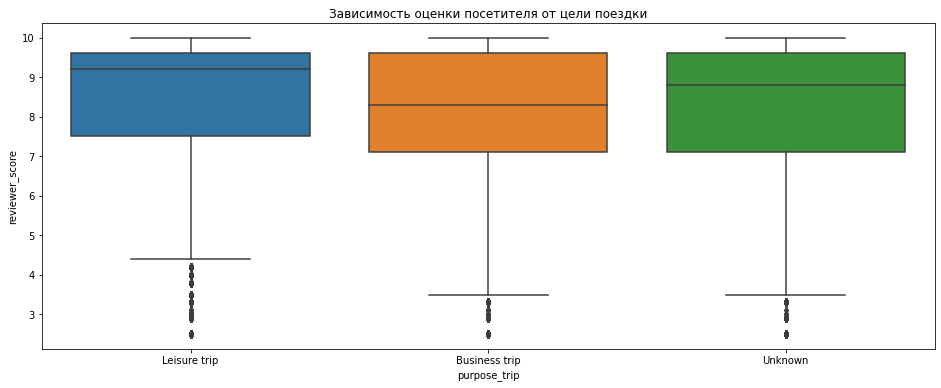

In [34]:
# Создадим функцию для создания признака 'purpose_trip'
def get_purpose(arg):
    if ' Business trip ' in arg:
        return 'Business trip'
    elif ' Leisure trip ' in arg:
        return 'Leisure trip'
    else:
        return 'Unknown'

data['purpose_trip'] = data['tags'].apply(get_purpose) # применим функцию
print(data['purpose_trip'].value_counts()) # посмотрим на распределение значений

# Визуализируем влияние на оценку
plt.figure(figsize=(16, 6))
plt.title("Зависимость оценки посетителя от цели поездки")
sns.boxplot(data=data[data['sample']==1], x='purpose_trip', y='reviewer_score') 

По графику видно, что посетители, цель поездки которых - отдых, ставят оценки выше, чем те, кто путешествует по работе. Значит оставим этот признак, только видоизменим его так, чтобы получилось два бинарных признака: 'business trip' и 'leisure trip'.

In [35]:
data['business_trip'] = data['purpose_trip'].apply(lambda x: 1 if x == 'Business trip' else 0)
data['leisure_trip'] = data['purpose_trip'].apply(lambda x: 1 if x == 'Leisure trip' else 0)
data = data.drop('purpose_trip', axis=1)

Среди тэгов встречается множество таких, которые указывают на сколько ночей остановились посетители. Создадим признак, который будет указывать на длительность пребывания:

In [36]:
# Напишем функцию
def get_count_days(row):
    for elem in row:
        if 'Stayed' in elem:
            return elem
    return 'Unknown'

data['stayed_period'] = data['tags'].apply(get_count_days) # Применим её
print(data['stayed_period'].nunique()) # Выведем количество уникальных значений
data['stayed_period'].value_counts() # Посмотрим на распределение

32


 Stayed 1 night       193645
 Stayed 2 nights      133937
 Stayed 3 nights       95821
 Stayed 4 nights       47817
 Stayed 5 nights       20845
 Stayed 6 nights        9776
 Stayed 7 nights        7399
 Stayed 8 nights        2502
 Stayed 9 nights        1293
 Stayed 10 nights        889
 Stayed 11 nights        418
 Stayed 12 nights        316
 Stayed 14 nights        247
 Stayed 13 nights        246
Unknown                  192
 Stayed 15 nights        117
 Stayed 16 nights         57
 Stayed 17 nights         42
 Stayed 18 nights         33
 Stayed 19 nights         29
 Stayed 21 nights         23
 Stayed 20 nights         19
 Stayed 27 nights         11
 Stayed 30 nights         11
 Stayed 23 nights         10
 Stayed 22 nights         10
 Stayed 25 nights          7
 Stayed 26 nights          7
 Stayed 28 nights          7
 Stayed 24 nights          6
 Stayed 29 nights          5
 Stayed 31 nights          1
Name: stayed_period, dtype: int64

Мы видим, что основное количество поездок приходится на короткий период пребывания 1-5 дней, очень мало поездок 20 и больше дней, поэтому поездки 20 дней и больше можно объединить в одну группу, поездки длительностью 10-19 дней также можно объединить и посмотреть насколько данный признак влияет на оценку.

<AxesSubplot:title={'center':'Зависимость оценки посетителя отеля в завимимости от срока пребывания'}, xlabel='stayed_period', ylabel='reviewer_score'>

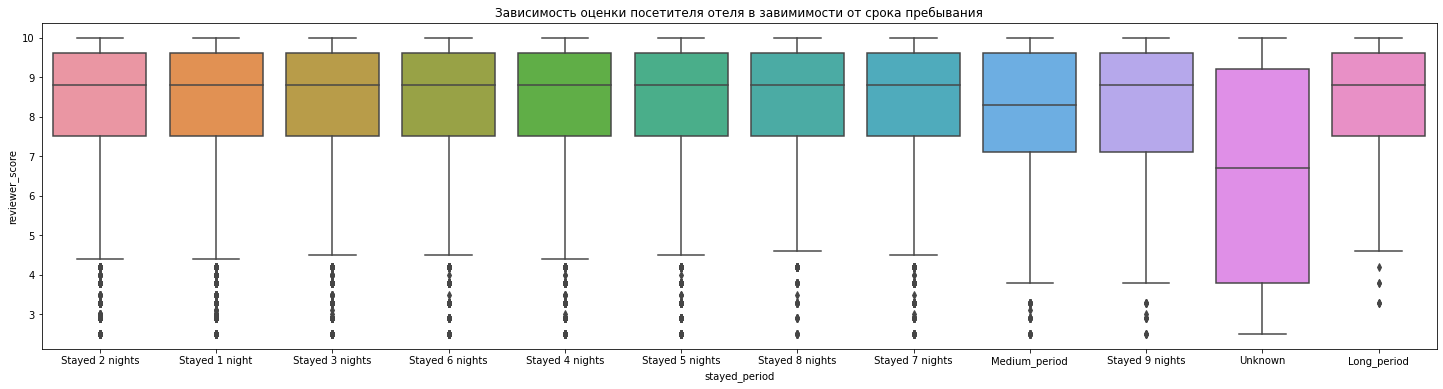

In [37]:
def get_trip_period(str_):
    if str_ == 'Unknown':
        return str_
    else:
        if int(str_.split()[1]) >= 20:
            return 'Long_period'
        elif 10 <= int(str_.split()[1]) < 20:
            return 'Medium_period'
        return str_

data['stayed_period'] = data['stayed_period'].apply(get_trip_period) # применим функцию

# Визуализируем влияние на оценку     
plt.figure(figsize=(25, 6))
plt.title("Зависимость оценки посетителя отеля в завимимости от срока пребывания")
sns.boxplot(data=data[data['sample']==1], x='stayed_period', y='reviewer_score') 

Почти все диаграммы на данном графике одинаковы, это говорит о том, что оценка не зависит от количества дней пребывания. Поэтому я принял решение удалить этот признак. 

In [38]:
data = data.drop('stayed_period', axis=1)

Внимательно посмотрев на тэги, можно заметить, что среди них указано в каком составе осуществляется поездка: 
  + Solo traveler
  + Couple
  + Group
  + Family with older children
  + Family with young children

Введем новый признак travelers_count, который будет показывать сколько путешественников осуществляют поездку:

 Couple                         252294
 Solo traveler                  108545
 Group                           65392
 Family with young children      61015
 Family with older children      26349
Unknown                           2143
Name: travelers_count, dtype: int64


<AxesSubplot:title={'center':'Вляние состава путешественников на оценку посетителя'}, xlabel='travelers_count', ylabel='reviewer_score'>

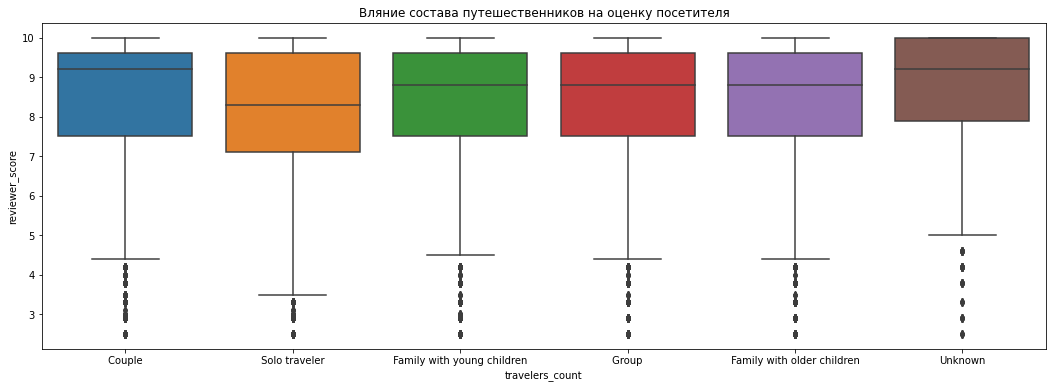

In [39]:
# Создадим список из интересующих нас тэгов
travelers_list = [' Solo traveler ', ' Couple ', ' Group ', 
                ' Family with older children ', ' Family with young children ']

# Напишем функцию
def get_travelers_count(lst):
    for elem in lst:
        if elem in travelers_list:
            return elem
    return 'Unknown'
    
data['travelers_count'] = data['tags'].apply(get_travelers_count) # создадим новый признак
print(data['travelers_count'].value_counts()) # посмотрим на распределение

# Визуализируем
plt.figure(figsize=(18, 6))
plt.title("Вляние состава путешественников на оценку посетителя")
sns.boxplot(data=data[data['sample']==1], x='travelers_count', y='reviewer_score') 

Мы видим, что состав участников путешествия оказывает влияние на оценку, но этот признак нужно видоизменить. Диаграмма показывает, что значения Group, Family with young children, Family with older children имеют идентичные диаграммы, поэтому их можно объединить в один признак Group. Остальные признаки оставим как есть. Итого получится 3 бинарных признака.

In [40]:
group_list = [' Group ', ' Family with older children ', ' Family with young children ']

data['couple_of_travellers'] = data['travelers_count'].apply(lambda x: 1 if x ==' Couple ' else 0)
data['solo_traveler'] = data['travelers_count'].apply(lambda x: 1 if x ==' Solo traveler ' else 0)
data['group_of_travellers'] = data['travelers_count'].apply(lambda x: 1 if x in group_list else 0)
data = data.drop('travelers_count', axis=1)

Еще один очень популярный признак - Submitted from a mobile device. Создадим колонку с этим признаком и посмотрим, влияет ли он на оценку:

1    307640
0    208098
Name: Submitted_from_a_mobile_device, dtype: int64


<AxesSubplot:title={'center':'Влияние признака Submitted from a mobile device на оценку'}, xlabel='Submitted_from_a_mobile_device', ylabel='reviewer_score'>

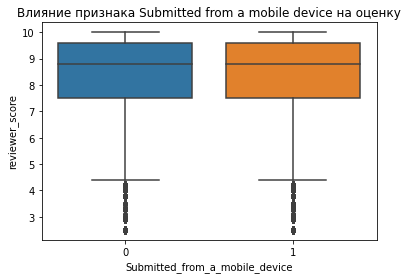

In [41]:
# Создадим признак
data['Submitted_from_a_mobile_device'] = data['tags'].apply(lambda x: 1 if ' Submitted from a mobile device ' in x else 0)

print(data['Submitted_from_a_mobile_device'].value_counts()) # посмотрим на распределение
plt.title("Влияние признака Submitted from a mobile device на оценку")
sns.boxplot(data=data[data['sample']==1], x='Submitted_from_a_mobile_device', y='reviewer_score') # визуализируем

Как видно на графике, нет никакой разницы от того, оставлен с мобильного телефона или с другого устройства, поэтому этот признак можно смело удалить:

In [42]:
data = data.drop('Submitted_from_a_mobile_device', axis=1)

Большинство тэгов описывают количество комнат и класс жилья одним тэгом. Что касается количества комнат, то не думаю, что этот признак будет оказывать влияние на оценку, гораздо важнее на мой взгляд выделить класс жилья. Сделать мы это можем по ключевым словам, таким как Comfort, Luxury, Standard_class и т.д. Выделим 3 категории: стандарт, комфорт и люкс.

Standard_class    319716
Comfort_class     107776
Luxury_class       88246
Name: room_class, dtype: int64


<AxesSubplot:title={'center':'Влияние класса номера на оценку'}, xlabel='room_class', ylabel='reviewer_score'>

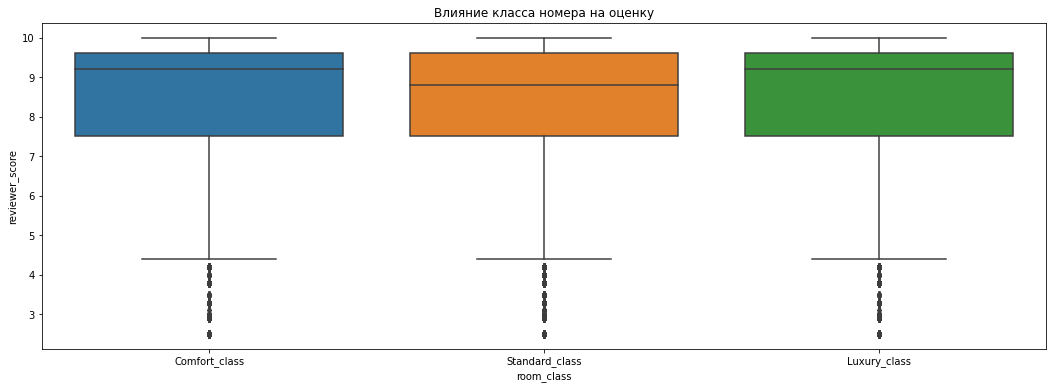

In [43]:
# Напишем функцию, которая по ключевым словам в тэгах будет определять класс номера. Если не указан класс жилья в тэгах, 
# то будем считать что это номер класса стандарт. Отмечу, что важно начинать именно с люкс категории, потому что если в 
# тэге присутствует 2 слова из разных категорий, например Suite и Luxury, то этот тэг нужно отнести именно к категории люкс.  
def get_class_room(row):
    for elem in row:
        if 'Executive' in elem or 'Deluxe' in elem or 'Luxury' in elem or 'Royal' in elem:
            return 'Luxury_class'
        elif 'Comfort' in elem or 'Superior' in elem or 'Suite' in elem:
            return 'Comfort_class'
    return 'Standard_class'
            
data['room_class'] = data['tags'].apply(get_class_room) # применим функцию
print(data['room_class'].value_counts()) # посмотрим на распределение

# Визуализируем
plt.figure(figsize=(18, 6))
plt.title("Влияние класса номера на оценку")
sns.boxplot(data=data[data['sample']==1], x='room_class', y='reviewer_score')

График показал, что номера люкс и комфорт-класса имеют оценку чуть выше, чем стандарт. Поэтому оставим этот признак, создав 3 бинарных признака:

In [44]:
data['standard_class'] = data['room_class'].apply(lambda x: 1 if x == 'Standard_class' else 0)
data['comfort_class'] = data['room_class'].apply(lambda x: 1 if x == 'Comfort_class' else 0)
data['luxury_class'] = data['room_class'].apply(lambda x: 1 if x  == 'Luxury_class' else 0)
data = data.drop('room_class', axis=1)

Среди тэгов встречаются те, котрые указывают, что в номере присутствует кровать размера king(queen)-size. Предполагаю что этот признак может оказать влияние на итоговую оценку. Создадим данный признак и посмотрим, так ли это:

0    444160
1     71578
Name: king_queen_bed, dtype: int64


<AxesSubplot:title={'center':'Влияние наличия кровати большого размера на оценку'}, xlabel='king_queen_bed', ylabel='reviewer_score'>

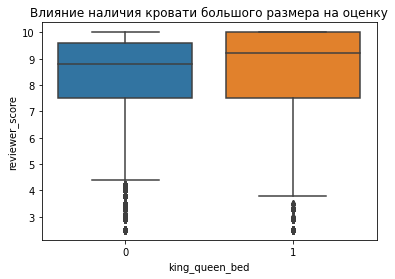

In [45]:
# Напишем функцию, которая возвращает 1, если кровать такого класса есть и 0, если нет
def is_big_bed(row):
    for elem in row:
        if 'King' in elem or 'king' in elem or 'Queen' in elem or 'queen' in elem:
            return 1
    return 0

data['king_queen_bed'] = data['tags'].apply(is_big_bed) # Применим функцию
print(data['king_queen_bed'].value_counts()) # посмотрим на распределение

# Визуализируем
plt.title("Влияние наличия кровати большого размера на оценку")
sns.boxplot(data=data[data['sample']==1], x='king_queen_bed', y='reviewer_score')

График показал, что номера, в которых имеется кровать большого размера, получают оценки чуть лучше, поэтому оставим этот признак. Что касается признака tags, то я считаю, что мы вытащили всю нужную информацию из него, поэтому его можно удалить.

In [46]:
data = data.drop('tags', axis=1)

# 3.5 Признак review_date

Что может нам дать данный признак? Этот признак можно привести к формату datetime и вытащить из него день, месяц или год. Думаю, что следует проверить 3 гипотезы, оказывает ли влияние на оценку то, 
  + в каком году поставлена оценка
  + в каком месяце поставлена оценка
  + в какое время года поставлена оценка
  
Проверим эти гипотезы:

In [47]:
data['review_date'] = pd.to_datetime(data['review_date']) # преобразуем в дататайм

data['year'] = data['review_date'].dt.year # создадим признак year
data['month'] = data['review_date'].dt.month # создадим признак month

# Напишем функцию для выделения времени года
def get_season(elem):
    if elem == 12 or elem <= 2:
        return 1
    elif 2 < elem <= 5:
        return 2
    elif 5 < elem <= 8:
        return 3
    return 4

data['season'] = data['month'].apply(get_season) # создадим признак season

Теперь отразим на графике новые признаки и решим, что делать с ними дальше

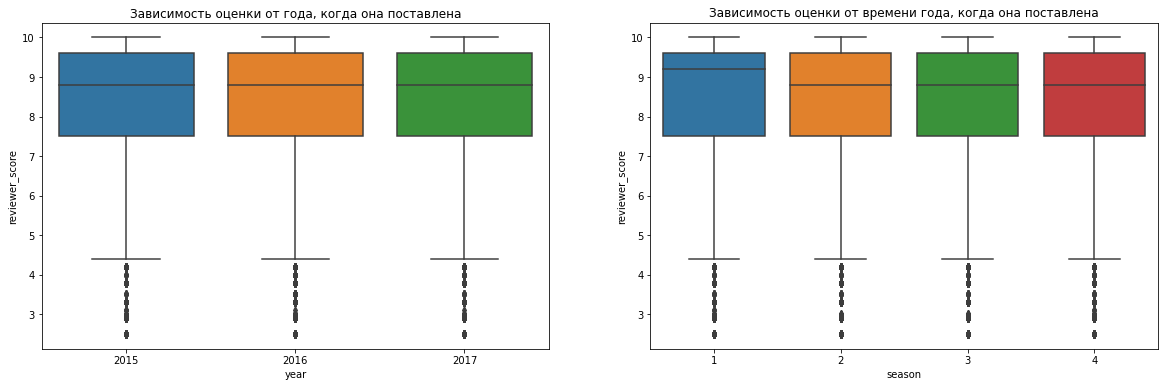

In [48]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.title("Зависимость оценки от года, когда она поставлена")
sns.boxplot(data=data[data['sample']==1], x='year', y='reviewer_score')

plt.subplot(1, 2, 2)
plt.title("Зависимость оценки от времени года, когда она поставлена")
sns.boxplot(data=data[data['sample']==1], x='season', y='reviewer_score')

plt.show()

<AxesSubplot:title={'center':'Зависимость оценки от месяца, когда она поставлена'}, xlabel='month', ylabel='reviewer_score'>

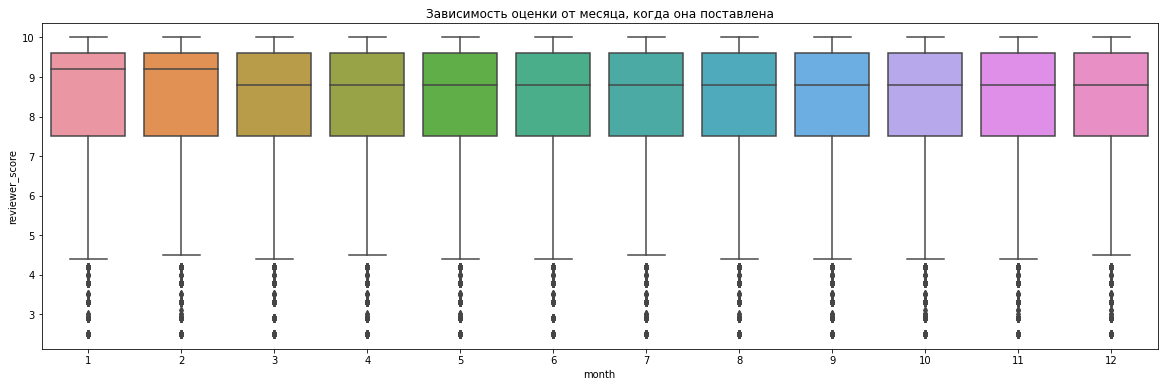

In [49]:
plt.figure(figsize=(20, 6))
plt.title("Зависимость оценки от месяца, когда она поставлена")
sns.boxplot(data=data[data['sample']==1], x='month', y='reviewer_score')

График показал, что в январе и феврале оценки чуть выше и соответственно если сравнивать времена года, то зимой оценки чуть выше. Возможно в январе и феврале люди чаще путешествуют, в том числе и на Новогодние праздники, а как мы выяснили ранее, такие поездки оцениваются лучше, чем рабочие поездки. Исходя из этого, я принял решение создать признак begin_of_year, который будет принимать значение 1, если месяц январь или февраль, в противном случае 0. Остальные созданные признаки я удалю.

In [50]:
data['is_begin_of_year'] = data['month'].apply(lambda x: 1 if x in [1, 2] else 0)
data = data.drop(['year', 'month', 'season', 'review_date'], axis=1)

# 3.6. Признак negative_review, positive_review

Посмотрим что из себя представляют данные признаки и как они связаны:

In [51]:
data[['negative_review', 'review_total_negative_word_counts', 'positive_review', 'review_total_positive_word_counts']].head()

,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts
0,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62
1,No tissue paper box was present at the room,10,No Positive,0
2,Pillows,3,Nice welcoming and service,5
3,No Negative,0,Everything including the nice upgrade The Hot...,27
4,No Negative,0,Lovely hotel v welcoming staff,7


Мы видим, что есть такие строки в которых есть и негативный отзыв и позитивный, а есть строго позитивные и трого негативные строки. Нам следует определить и те и другие, а в строках и с позитивом и с негативом нам следует определить насколько сильно позитивен или негативен отзыв. Для начала я хочу определить строго негативные и позитивные отзывы. Начнем с колонки negative_review. Если в отзыве нет негатива, то он обычно состоит из не более чем трех слов. Поэтому выведем на экран самые популярные короткие отзывы (не больше 3 слов) в колонке negative_review:

In [52]:
data[data['review_total_negative_word_counts'] <= 3]['negative_review'].value_counts().head(50).index

Index(['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None',
       ' ', ' N a', ' Breakfast', ' Small room', ' Location', ' Everything',
       ' All good', ' Nothing really', ' none', ' nothing ', ' No complaints',
       ' Price', ' Nil', ' n a', ' Small rooms', ' None ', ' NA', ' Expensive',
       ' Room size', ' Staff', ' No', ' Leaving', ' Leaving ', ' NOTHING',
       ' See above', ' Na', ' small room', ' Liked everything', ' breakfast',
       ' Non', ' Expensive breakfast', ' Absolutely nothing', ' Not much',
       ' Not applicable', ' Pillows', ' Parking', ' Wifi', ' location',
       ' The price', ' No parking', ' As above', ' Noise', ' No thing',
       ' Bathroom'],
      dtype='object')

Как видим короткие отзывы имеют очень много вариантов написания, но среди них можно выделить несколько типов:
  - отзывы, в которых нет ничего, чтобы не понравилось, мы приведем их к единому виду 'Nothing dislike';
  - отзывы, в которых не понравилось все, приведем их к виду 'Everything dislike';
  - отзывы, в которых указано, что не было чего-либо, приведем их к виду 'No anything';
  - остальные, это те в которых не понравилось что-то одно, приведем их к виду 'Anything is not good'

In [53]:
# Cоздадим вручную список отзывов без негатива
no_negative_list = ['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None', ' ', 
                    ' N a', ' All good', ' Nothing really', ' none', ' nothing ', ' No complaints',
                    ' Nil', ' n a', ' None ', ' NA', ' No', ' NOTHING', ' Na', ' Liked everything', 
                    ' Non', ' Absolutely nothing', ' Not much', ' No thing', ' nothing really', ' all good',
                    ' All ok', ' no complaints', ' no', ' No negatives', ' nil', ' No dislikes', 
                    ' Loved everything', ' NOTHING ', ' No problems', ' No comment', ' No issues', ' non',
                    ' No problems', ' No comment', ' Nada', ' Nothing special', ' No comments', ' Nothing bad', 
                    ' All great', ' Nil ', ' none ', ' No faults', ' Nothing much', ' Nithing', ' All fine', 
                    ' Noting', ' no thing', ' NIL', ' See above', ' As above', ' Nada ', ' not much', ' na', 
                    ' Nothings', ' Nothin']

# Список отзывов, где не понравилось всё
everything_bad_list = [' Everything', ' Leaving', ' Leaving ', ' All', ' everything', ' Everything ',
                       ' Every thing', ' Service', ' Everything else', ' Facilities', ' Not applicable', 
                       ' leaving']

# Напишем функцию для преобразования
def update_neg_review(elem):
    if elem in no_negative_list:
        return 'Nothing dislike'
    elif elem in everything_bad_list:
        return 'Everything dislike'
    elif ' No ' in elem or ' no ' in elem:
        return 'No anything'
    return 'Anything is not good'

# Применим функцию
short_neg_review = data['review_total_negative_word_counts'] <= 3
data.loc[short_neg_review, ['negative_review']] = data['negative_review'].apply(update_neg_review)
    
# Взглянем на распределение
data[data['review_total_negative_word_counts'] <= 3]['negative_review'].value_counts()

Nothing dislike         156266
Anything is not good     12603
Everything dislike         908
No anything                904
Name: negative_review, dtype: int64

Отлично! Теперь проделаем то же самое с позитивными отзывами:

In [54]:
# Посмотрим на эти отзывы
data[data['review_total_positive_word_counts'] <= 3]['positive_review'].value_counts().head(50).index

Index(['No Positive', ' Location', ' Everything', ' location', ' Nothing',
       ' The location', ' Great location', ' Good location', ' Location ',
       ' Everything ', ' Breakfast', ' Friendly staff', ' Staff',
       ' Excellent location', ' everything', ' Nothing ', ' Comfy bed',
       ' nothing', ' good location', ' The staff', ' Good breakfast', ' ',
       ' the location', ' Location staff', ' All', ' Every thing',
       ' Perfect location', ' Clean', ' Cleanliness', ' great location',
       ' Comfortable bed', ' Great breakfast', ' breakfast',
       ' Excellent breakfast', ' Position', ' Helpful staff',
       ' Central location', ' Location Staff', ' The bed', ' Location only',
       ' The room', ' Not much', ' Great staff', ' Room',
       ' Convenient location', ' All good', ' The breakfast',
       ' friendly staff', ' Excellent', ' Excellent staff'],
      dtype='object')

Здесь также можно выделить несколько типов:
  - отзывы, в которых нет ничего, чтобы понравилось, мы приведем их к единому виду 'Nothing like';
  - отзывы, в которых понравилось все, приведем их к виду 'Everything is good';
  - остальные отзывы, это как правило те в которых не понравилось что-то одно, в основном это локация или завтрак. Но я не вижу смысла разделять их на категории, потому что для оценки этого отзыва не имеет разницы good location или good breakfast, поэтому приведем все подобные отзывы к виду 'Anything like'.

In [55]:
no_positive_list = ['No Positive', ' Nothing', ' Nothing ', ' nothing', ' Not much', ' ', ' N A', ' No', 
                    ' None', ' Nothing special', ' Nothing really']

everything_good_list = [' Everything', ' Everything ', ' everything', ' All', ' Every thing', ' All good', 
                        ' Perfect', ' Nice hotel', ' everything ', ' Almost everything', ' all', 
                        ' Great hotel', ' every thing', ' Excellent hotel', ' Great', ' Perfect ', 
                        ' Excellent ', ' Amazing', ' EVERYTHING', ' Beautiful hotel', ' Excellent service',
                        ' Very good', ' Lovely hotel', ' Great service']

# Напишем функцию для преобразования
def update_pos_review(elem):
    if elem in no_positive_list:
        return 'Nothing like'
    elif elem in everything_good_list:
        return 'Everything is good'
    return 'Anything like'

short_pos_review = data['review_total_positive_word_counts'] <= 3
data.loc[short_pos_review, ['positive_review']] = data['positive_review'].apply(update_pos_review)

data[data['review_total_positive_word_counts'] <= 3]['positive_review'].value_counts()

Nothing like          38052
Anything like         36986
Everything is good     4375
Name: positive_review, dtype: int64

Мы обработали все короткие отзывы. Что касается длинных отзывов, то я заметил, что часто люди не ставят знак <'>, поэтому получается не don't a don t. Программа не распознает это как отрицание и как итог - неправильно считает тональность. Это следует исправить, сделаем это:

In [56]:
# Создадим список неправильно записанных сокращений
wrong_word_list = ["don t", "Don t", "didn t", "Didn t", "wouldn t","Wouldn t", "couldn t", "Couldn t", 
                   "wasn t", "Wasn t", "aren t", "isn t", "Isn t", "doesn t", "Doesn t", "weren t", 
                   "Weren t", "hasn t", "haven t", "Haven t", "won t", "Won t", "shouldn t", "Shouldn t"]

# Напишем корректирующую функцию
def correct_func(elem):
    for word in wrong_word_list:
        if word in elem:
            return elem.replace(word, word.replace(" ", "'"))
    return elem

# Применим ее
data['negative_review'] = data['negative_review'].apply(correct_func)
data['positive_review'] = data['positive_review'].apply(correct_func)

Теперь создадим 2 новых столбца 'positive_score' и 'negative_score', в которые будем записывать значение тональности текста в колонках 'positive_review' и 'negative_review' соответственно. Использовать будем анализатор тональности:

In [57]:
sent_analyzer = SentimentIntensityAnalyzer()

data['negative_score'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
data['positive_score'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

data[['negative_review', 'positive_review', 'negative_score', 'positive_score']].head(15)

,negative_review,positive_review,negative_score,positive_score
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...,-0.0554,0.9615
1,No tissue paper box was present at the room,Nothing like,-0.2960,0.3612
2,Anything is not good,Nice welcoming and service,-0.3412,0.6908
3,Nothing dislike,Everything including the nice upgrade The Hot...,-0.3818,0.9153
4,Nothing dislike,Lovely hotel v welcoming staff,-0.3818,0.7717
5,They don't have free wifi,The location is perfect if you don't have a l...,-0.4023,0.6124
6,Room generally a bit shabby with some lack of...,Location price It did not cost much more to h...,0.1280,0.5106
7,Executive rooms 9th Floor don't have a bath T...,Comphy bed upgraded to executive room with ne...,0.6124,0.5859
8,Pity about the two days of rain,Its centrality proximity to our destination,-0.2960,0.0000
9,Didn't like it at all construction was in pro...,Didn't like anything about the stay if i had ...,-0.2287,-0.2755


Значения выглядят довольно корректными. Теперь мы можем сократить количество столбцов. Сначала выведем среднюю оценку 'negative_score' и 'positive_score' и поместим в столбец 'mean_score', а затем удалим столбцы negative_review, positive_review, 'negative_score' и 'positive_score'

In [58]:
data['mean_score'] = (data['negative_score'] + data['positive_score']) / 2 
data = data.drop(['negative_review', 'positive_review', 'negative_score', 'positive_score'], axis=1)

## 3.7. Признак review_total_negative_word_counts, review_total_positive_word_counts

Данные признаки думаю можно подразделить на категории:
  - короткие отзывы (не более 5 слов);
  - средние (от 6 до 20 слов);
  - длинные (более 20 слов)

Создадим 2 признака - длина негативного отзыва и длина позитивного отзыва, применим к ним метод порядкового кодирования, а затем удалим признаки review_total_negative_word_counts и review_total_positive_word_counts.

In [59]:
# Напишем функцию, определяющую длину
def get_review_leight(elem):
    if elem <= 5:
        return "Short"
    elif 5 < elem <= 20:
        return "Medium"
    return "Long"

# Применим ее
data['negative_review_leight'] = data['review_total_negative_word_counts'].apply(get_review_leight)
data['positive_review_leight'] = data['review_total_positive_word_counts'].apply(get_review_leight)

# Применим порядковое кодирование
ord_encoder = ce.OrdinalEncoder()
leight_review_ord = ord_encoder.fit_transform(data[['negative_review_leight', 'positive_review_leight']])

# Объединим датафреймы
data = pd.concat([data, leight_review_ord], axis=1)

# Удалим ненужные столбцы
data = data.drop(['review_total_negative_word_counts', 'review_total_positive_word_counts', 'negative_review_leight', 'positive_review_leight'], axis=1)

Теперь у нас остался всего один признак с типом данных object - это столбец 'hotel_name'. Можем смело удалить его, так как он по сути дублирует столбцы с координатами.

In [60]:
data = data.drop('hotel_name', axis=1)

## 3.8 Нормализация числовых признаков 

В нашем датасете осталось четыре таких признака: 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'days_since_review'. Взглянем для начала как они распределены:

In [61]:
data[['additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'days_since_review']].describe()

,additional_number_of_scoring,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review
count,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,2743.743944,7.166001,354.441932
std,500.538467,2317.464868,11.040228,208.928124
min,1.000000,43.000000,1.000000,0.000000
25%,169.000000,1161.000000,1.000000,175.000000
50%,341.000000,2134.000000,3.000000,353.000000
75%,660.000000,3613.000000,8.000000,527.000000
max,2682.000000,16670.000000,355.000000,730.000000


Ожидаемо, что данные признаки распределены ненормально и имеют выбросы. Поэтому применим к ним метод нормализации Robustscaler:

In [62]:
# Инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# Создадим список имен столбцов
col_names = ['additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'days_since_review']

df_norm = r_scaler.fit_transform(data[col_names]) # произведем нормализацию столбцов
df_norm = pd.DataFrame(df_norm, columns=col_names) # преобразуем в датафрейм
data = data.drop(col_names, axis=1) # удалим исходные столбцы
data = pd.concat([data, df_norm], axis=1) # добавим новые

data.info() # посмотрим какие получились столбцы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   lat                                         515738 non-null  float64
 2   lng                                         515738 non-null  float64
 3   sample                                      515738 non-null  int64  
 4   reviewer_score                              515738 non-null  float64
 5   hotel_city_Milan                            515738 non-null  int64  
 6   hotel_city_Amsterdam                        515738 non-null  int64  
 7   hotel_city_Barcelona                        515738 non-null  int64  
 8   hotel_city_London                           515738 non-null  int64  
 9   hotel_city_Paris                            515738 non-null  int64  
 

# 3.9 Признаки lat и lng

Данные признаки выглядят так, будто они числовые, однако они являются категориальными. И как мы уже выяснили имеют одинаковое количество уникальных значений - по 1489 и каждому уникальному значению lat соответствует только одно уникальное значение lng, а значит эти признаки дублируют друг друга и не имеет смысла кодировать их обоих. Поэтому можно закодировать один из столбцов при помощи бинарного кодирования, а потом удалить их.

In [63]:
# Воспользуемся кодировщиком BinaryEncoder
bin_encoder = ce.BinaryEncoder(cols=['lat'])
lat_bin = bin_encoder.fit_transform(data['lat'])
data = pd.concat([data, lat_bin], axis=1)
data = data.drop(['lat', 'lng'], axis=1)

# 4. Отбор признаков

Рассмотрим корреляцию признаков:

<AxesSubplot:>

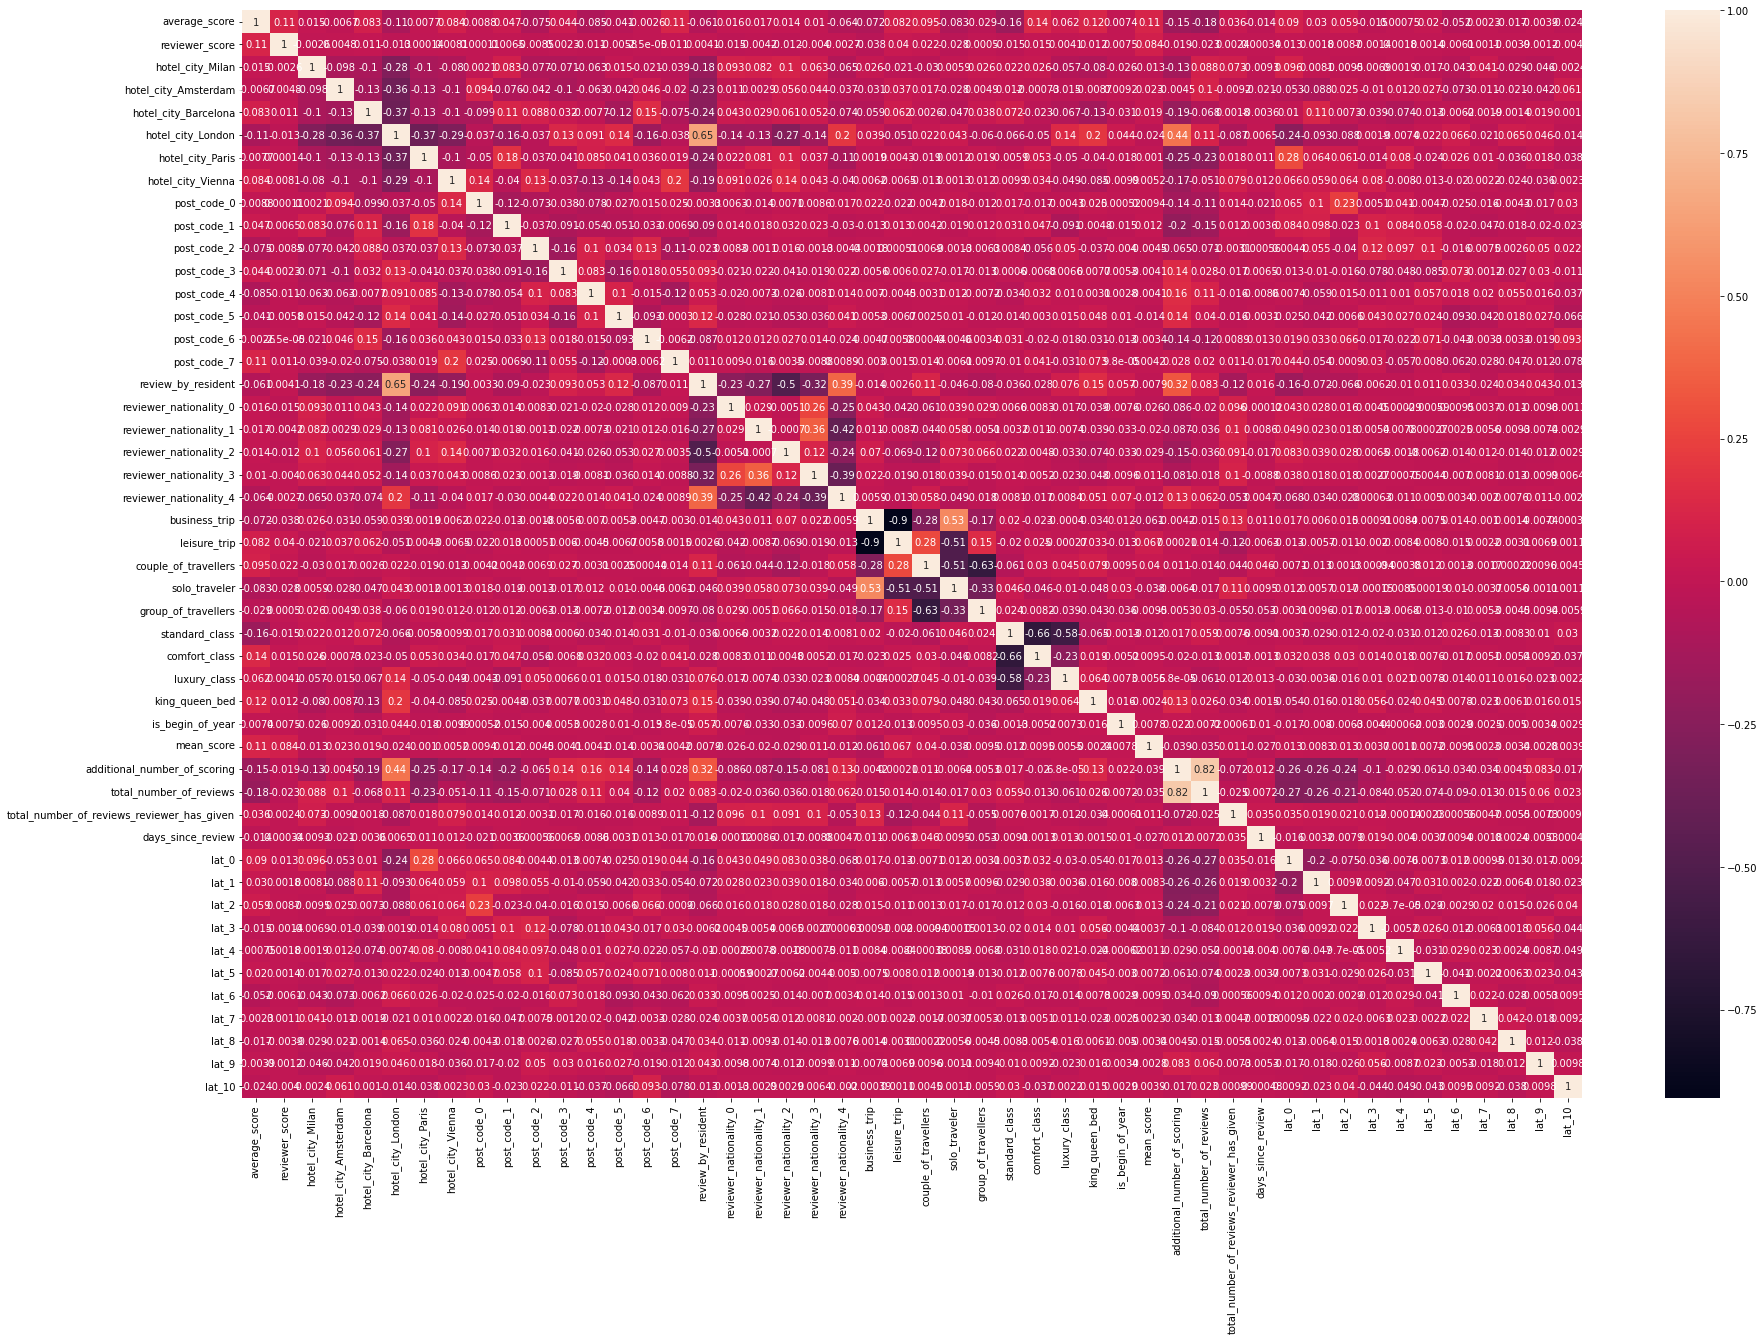

In [64]:
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Как мы видим на графике, у нас имеется 2 пары сильных корреляций: 
  - leisure trip и business trip
  - total_number_of_reviews и additional_number_of_scoring
  
Признаки additional_number_of_scoring и business trip я думаю можно смело удалить.

In [65]:
data = data.drop(['additional_number_of_scoring', 'business_trip'], axis=1)

# 5. Обучение модели

In [66]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
 
y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [67]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [68]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 46), (386803, 46), (386803, 45), (309442, 45), (77361, 45))

Почему-то после разбивки в некоторых колонках образовались пропуски. Заполним эти пропуски средним по столбцам

In [69]:
# Определим значения, которыми будем заполнять пропуски
values = {'total_number_of_reviews': data['total_number_of_reviews'].mean(), 
          'total_number_of_reviews_reviewer_has_given': data['total_number_of_reviews_reviewer_has_given'].mean(), 
          'days_since_review': data['days_since_review'].mean()} 

# Заполним пропуски
train_data = train_data.fillna(value=values)
X = X.fillna(value=values)
X_train = X_train.fillna(value=values)
X_test = X_test.fillna(value=values)

In [70]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [71]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [72]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [73]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 1.0427276696575913


<AxesSubplot:>

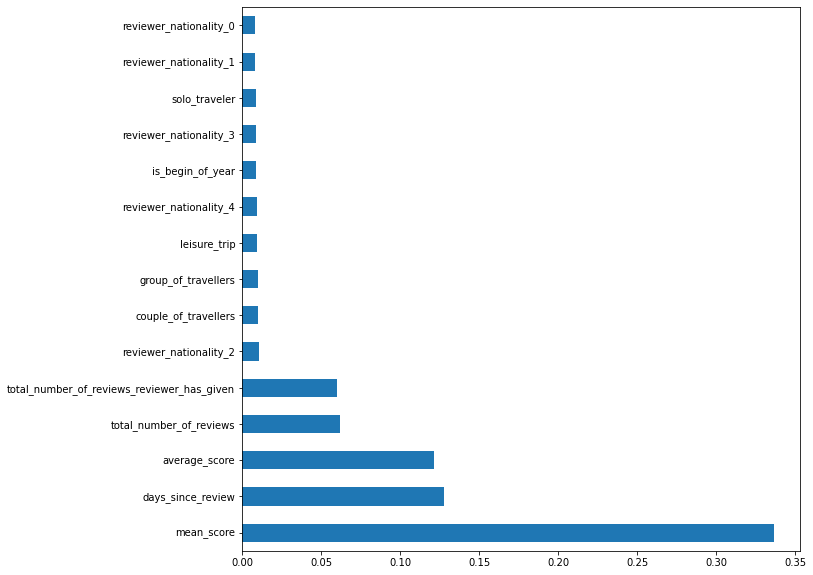

In [74]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [75]:
test_data.sample(10)

,average_score,reviewer_score,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna,post_code_0,post_code_1,...,lat_1,lat_2,lat_3,lat_4,lat_5,lat_6,lat_7,lat_8,lat_9,lat_10
115248,8.7,0.0,0,1,0,0,0,0,1,0,...,0,1,1,1,1,0,0,0,1,1
20689,8.6,0.0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
62768,8.4,0.0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,1,0,1,0
50045,8.0,0.0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,1,1,0,0
119108,8.6,0.0,0,0,0,1,0,0,0,1,...,0,0,1,1,0,1,1,1,1,0
26054,7.6,0.0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
10121,8.1,0.0,0,0,0,1,0,0,0,1,...,0,1,1,1,1,1,0,0,0,0
33095,8.3,0.0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
35393,8.5,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
66337,8.7,0.0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [76]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [77]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [78]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.3s finished


In [79]:
predict_submission

array([7.963, 7.805, 7.827, ..., 8.476, 9.424, 7.941])

In [80]:
list(sample_submission)

['reviewer_score', 'id']

In [81]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,7.963,488440
1,7.805,274649
2,7.827,374688
3,9.515,404352
4,9.332,451596
5,7.127,302161
6,8.731,317079
7,7.727,13963
8,7.755,159785
9,4.843,195089
